# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# for reading and displaying images
from skimage import io
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Tanh, Hardtanh, LeakyReLU, ELU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as f

from scipy.special import rel_entr
from math import sqrt
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = os.uname()
global device
if data[1] == 'lambda-dual':
    device = 'cuda:1'
    print('The model will be trained on {}'.format(device))
    data_dir = '/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('Data will be loaded from "{}"'.format(data_dir))
    print('Data will be saved to "{}"'.format(save_dir))
elif data[1] == 'linuxg3' or data[1] == 'linuxg4':
    device = 'cuda:0'
    data_dir = '/top/projects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/top/projects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('The model will be trained on {}'.format(device))
    print('Data will be saved to "{}"'.format(save_dir))
    

The model will be trained on cuda:1
Data will be loaded from "/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/"
Data will be saved to "/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/"


# Load dataset

In [3]:
# loading dataset
filenames = os.listdir(data_dir)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    img_stack.append(img)

# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')

# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('Input dataset specs:')
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

# process the input image stack
img_stack = torch.tensor(img_stack)
img_stack = img_stack.to(device)

tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])


Input dataset specs:
img width = 681, img height = 406, img channels = 9


# Define functions

In [18]:
class ResnetBlock(Module):
    def __init__(self, channels, kernel_size, stride, padding):
        super(ResnetBlock, self).__init__()
        self.conv = Sequential(
                        Conv2d(in_channels=channels, 
                          out_channels=channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, bias=False) )
        
    def forward(self, x):
        intermediate = self.conv(x)
        out = x + intermediate
        return out
        

class ScalableSat(Module):
    def __init__(self):
        super(ScalableSat, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([1.0,1.0,0.0]))
        self.tanh = Hardtanh()
        
    def forward(self,x):
        return self.a[1]*self.tanh(self.a[0]*x)+self.a[2]
    
class LeakyHardsigmoid(Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyHardsigmoid,self).__init__()
        self.ns = negative_slope
        
    def forward(self,x):
        return f.leaky_relu(-f.leaky_relu(-(x-3)/6,negative_slope=self.ns)+1,negative_slope=self.ns)

class OffsetHardsigmoid(Module):
    def __init__(self):
        super(OffsetHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.hardsigmoid(x-3)

class OffsetLeakyHardsigmoid(Module):
    def __init__(self):
        super(OffsetLeakyHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.rrelu(-f.rrelu(-(x-1),lower=0)+1,lower=0)
    
class AbsActivation(Module):
    def __init__(self):
        super(AbsActivation,self).__init__()
        
    def forward(self,x):
        return torch.abs(x)

class NormalizeEndmembers(Module):
    def forward(self,X):
        return X / X.norm(dim=0)
            
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1,bias=False),
            ReLU(),
            Conv2d(64, 64, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            Conv2d(64, 64, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            Conv2d(64, 64, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            Conv2d(64, 64, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            
            # Defining additional 2D convolution layer
            Conv2d(64, nch_bottleneck, kernel_size=1, stride=1, padding=0, bias=False),
            
            # implementing the v-notch nonlinearity
            nn.Hardtanh(),
            AbsActivation()
        )
        
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch_bottleneck, nch, kernel_size=1, stride=1,bias=False),  
            ScalableSat()
        )
       
        nn.utils.parametrize.register_parametrization(self.cnn_spectral_layers[0],"weight",NormalizeEndmembers())
        
        
    def getSOEMlayer(self):
        return self.cnn_spectral_layers[0]
    
    # Defining the forward pass    
    def forward(self, x):
        z = self.cnn_layers(x)
        y = self.cnn_spectral_layers(z)
        return y
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        y = self.cnn_spectral_layers(z)
        return y

    
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.uniform_(m.weight.data)
        
# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(1.2*img[:,:,0:3])
    plt.show()
    return img

# define latent space visualization function
def generate_z_image(ind, indices):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,indices[0:3],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    return 1.*img

def visualSummary(L1_loss, indices):
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,(1,4))
    img = generate_z_image(0, indices)
    plt.imshow(img)
    plt.subplot(2,3,(2,5))
    img = generate_z_image(1, indices)
    plt.imshow(img)
    plt.subplot(2,3,3)
    w = model.getSOEMlayer().weight
    w = w.detach().cpu().numpy().squeeze()
    tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
    plt.plot(tau,w[:,indices[0]],'r')
    plt.plot(tau,w[:,indices[1]],'g')
    plt.plot(tau,w[:,indices[2]],'b')
    plt.title('recovered endmembers')
    plt.xlabel('probe delay, ps')
    plt.subplot(2,3,6)
    plt.plot(L1_loss)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss')
    plt.tight_layout()
    plt.show()
    
# Custom Loss Functions
def meansq(x):
    return torch.mean((x-torch.mean(x))**2)

def corr(x,y):
    return torch.sum(x*y) / (torch.sqrt(torch.sum(x**2))*torch.sqrt(torch.sum(y**2)))

def SADLoss(weights):
    deriv = torch.nn.Parameter(weights[1:,]-weights[:-1,])
    sad = torch.sum(deriv**2)
    return sad

# model training routine definition
def train_model(model, n_epochs, img_stack, lr):
    
    # define loss function
    criterion = nn.L1Loss()
    
    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # initialize model weights and send to train device
    model.to(device) # load the model in the training device
    
    # define variables
    L1_loss = []
        
    # iterate over the epochs
    for epoch in tqdm(range(1, n_epochs+1)):
        # monitor training loss
        train_loss = 0.0

        # keep track of meansq value for each channel
        channelmsq = torch.zeros(nch_bottleneck).to(device)

        #Training
        for images in img_stack:
            images = images[None, :]
            image_x_p = torch.permute(images, (0, 3, 1, 2))
            image_x_p = image_x_p.to(device)
            optimizer.zero_grad()         
            z = model.forward_enc(image_x_p)
            outputs = model.forward_dec(z)
    
            # calculate the weighted L1 loss
            err_stack = image_x_p - outputs
            chan_weights = 1/torch.std(image_x_p,dim=(2,3))
            chan_weights = chan_weights / torch.sum(chan_weights)
            chan_weights[0] = 0.1
            l1_err_per_chan = torch.mean(torch.abs(err_stack),dim=(2,3))
            weighted_l1 = torch.mean(chan_weights * l1_err_per_chan)
            loss_recon = weighted_l1
            
            # variance-ordering
            channelmsq += torch.mean(z**2,dim=[2,3]).squeeze()
            
            # interchannel correlation loss
            zvec = z.squeeze().view(nch_bottleneck,-1)
            zvec = zvec-torch.mean(zvec,1,keepdim=True)
            zcov = torch.matmul(zvec,zvec.transpose(0,1))
            zstds = torch.sqrt(zcov.diag()).expand(1,-1)
            zstdprods = torch.matmul(zstds.transpose(0,1),zstds)
            zcorrabs = zcov / (zstdprods + 1e-6)
            loss_zcorr = (torch.sum(f.relu(zcorrabs.triu())) - zcorrabs.trace())

            # total loss
            loss = loss_recon + 0.001*loss_zcorr

            loss.backward()
            optimizer.step()
            train_loss += loss.item()*image_x_p.size(0)

        train_loss = train_loss/len(img_stack)
        L1_loss.append(train_loss)

        # rearrange channels so red has max variance, blue the least
        model.indices = channelmsq.argsort(descending=True)

        if epoch%200 == 0:
            visualSummary(L1_loss, model.indices)
        
    return L1_loss

def kl_divergence(A, B):
    return np.sum(A*np.log(A/B))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return (0.5 * kl_divergence(p, m)) + (0.5 * kl_divergence(q, m))

# Train model

Starting training of models on cuda:1


100%|███████████████████████████████████████████████████▋| 199/200 [00:46<00:00,  4.23it/s]

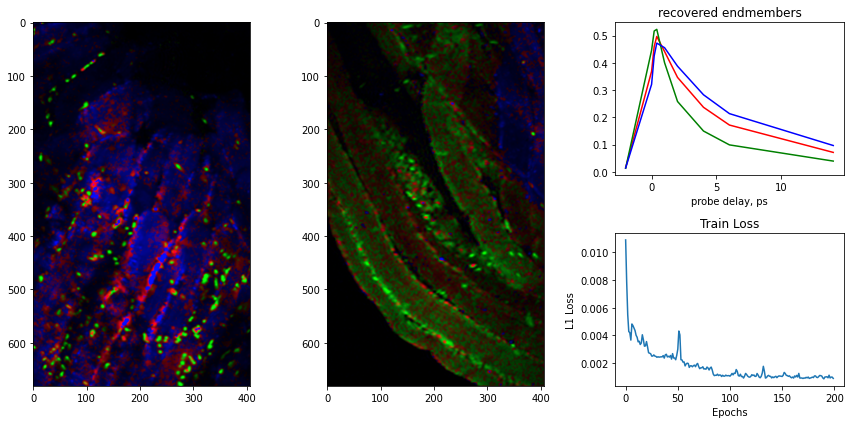

100%|████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.23it/s]


Runs done: 1/5


100%|███████████████████████████████████████████████████▋| 199/200 [00:47<00:00,  4.16it/s]

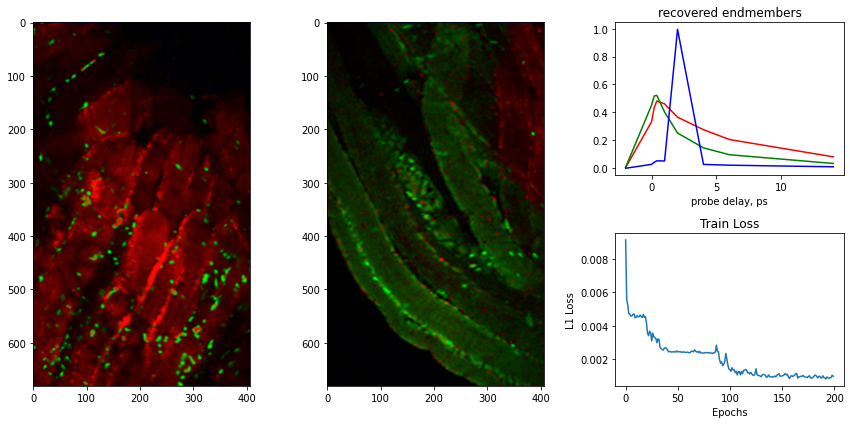

100%|████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.17it/s]


Runs done: 2/5


100%|███████████████████████████████████████████████████▋| 199/200 [00:47<00:00,  4.16it/s]

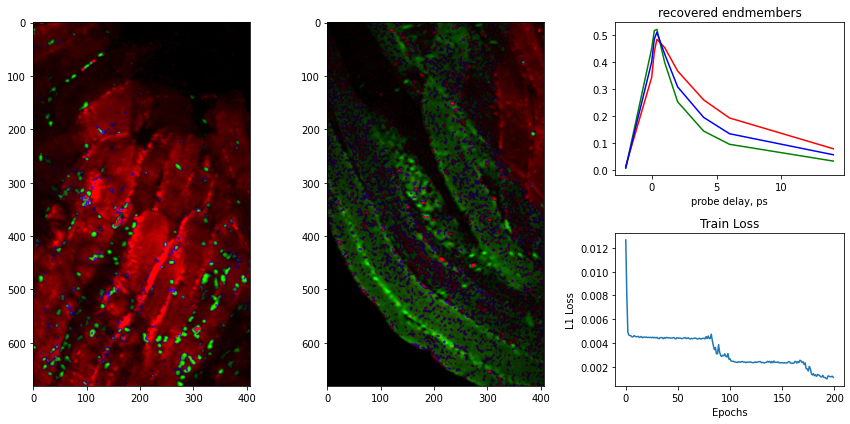

100%|████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.13it/s]


Runs done: 3/5


100%|███████████████████████████████████████████████████▋| 199/200 [00:47<00:00,  4.16it/s]

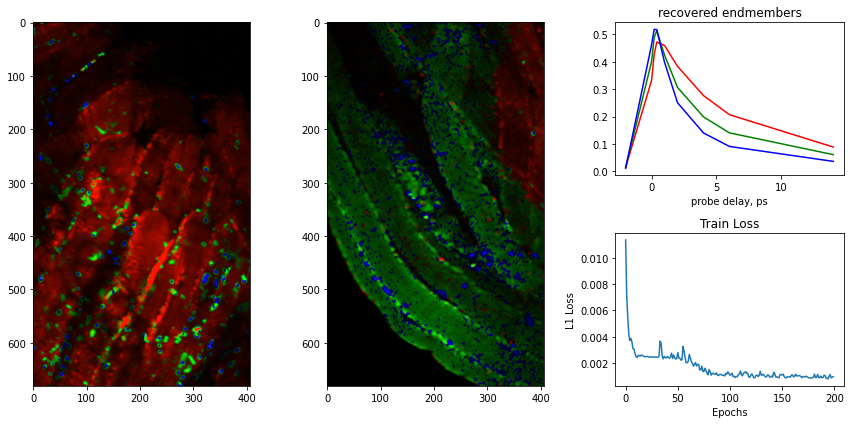

100%|████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.12it/s]


Runs done: 4/5


100%|███████████████████████████████████████████████████▋| 199/200 [00:47<00:00,  4.16it/s]

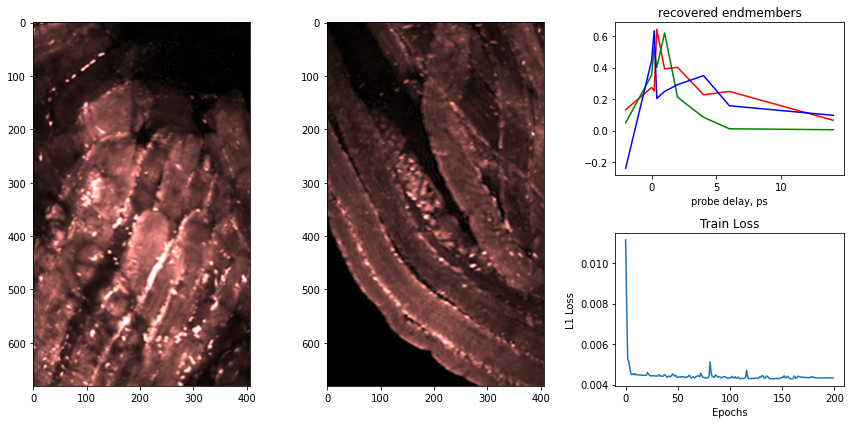

100%|████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.13it/s]

Runs done: 5/5


In [19]:
loss_arr = []

# number of times the experiment is repeated
n_runs = 5
n_epochs = 200
learning_rate = 1e-2
nch_bottleneck = 3

print('Starting training of models on {}'.format(device))
n_count = 0
for i in range(1,n_runs+1):
    model = Net()
    loss = train_model(model, n_epochs, img_stack, learning_rate)
    loss_arr.append(loss)
    n_count+=1
    print('Runs done: {}/{}'.format(n_count, n_runs))


# Analyze trained models

In [154]:
red_perm = []
ox_perm = []
red_intact = []
ox_intact = []

for files in filenames:
    if 'red perm' in files:
        img = io.imread(data_dir + files)
        red_perm.append(img)
        
    if 'ox perm' in files:
        img = io.imread(data_dir + files)
        ox_perm.append(img)
        
    if 'red intact' in files:
        img = io.imread(data_dir + files)
        red_intact.append(img)
        
    if 'ox intact' in files:
        img = io.imread(data_dir + files)
        ox_intact.append(img)

red_perm = np.array(red_perm)
ox_perm = np.array(ox_perm)
red_intact = np.array(red_intact)
ox_intact = np.array(ox_intact)    

print('red_perm shape = {}, ox_perm shape = {}, red_intact shape = {}, ox_intact shape = {}'.format(red_perm.shape, 
     ox_perm.shape, red_intact.shape, ox_intact.shape))

red_perm = red_perm.astype('float32')
ox_perm = ox_perm.astype('float32')
red_intact = red_intact.astype('float32')
ox_intact = ox_intact.astype('float32')

img_stack_rp = torch.tensor(red_perm)
img_stack_rp = img_stack_rp.to(device)
img_stack_op = torch.tensor(ox_perm)
img_stack_op = img_stack_op.to(device)
img_stack_ri = torch.tensor(red_intact)
img_stack_ri = img_stack_ri.to(device)
img_stack_oi = torch.tensor(ox_intact)
img_stack_oi = img_stack_oi.to(device)

preds = []
for data in img_stack:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds.append(img)
preds = np.array(preds)
print(preds.shape)

preds_rp = []
for data in img_stack_rp:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_rp.append(img)
preds_rp = np.array(preds_rp)
print(preds_rp.shape)

preds_op = []
for data in img_stack_op:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_op.append(img)
preds_op = np.array(preds_op)
print(preds_op.shape)

preds_ri = []
for data in img_stack_ri:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_ri.append(img)
preds_ri = np.array(preds_ri)
print(preds_ri.shape)

preds_oi = []
for data in img_stack_oi:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_oi.append(img)
preds_oi = np.array(preds_oi)
print(preds_oi.shape)

preds = np.swapaxes(preds, 0, 3)
print(preds.shape)
preds_rp = np.swapaxes(preds_rp, 0, 3)
print(preds_rp.shape)
preds_op = np.swapaxes(preds_op, 0, 3)
print(preds_op.shape)
preds_ri = np.swapaxes(preds_ri, 0, 3)
print(preds_ri.shape)
preds_oi = np.swapaxes(preds_oi, 0, 3)
print(preds_oi.shape)

"convert data from [M, nx, ny, c] to [c, (M*nx*ny)] shape"
preds_rolled = []
for img in preds:
    rolled_img = np.ravel(img)
    preds_rolled.append(rolled_img)
preds_rolled = np.array(preds_rolled)
print(preds_rolled.shape)

preds_rolled_rp = []
for img in preds_rp:
    rolled_img = np.ravel(img)
    preds_rolled_rp.append(rolled_img)
preds_rolled_rp = np.array(preds_rolled_rp)
print(preds_rolled_rp.shape)

preds_rolled_op = []
for img in preds_op:
    rolled_img = np.ravel(img)
    preds_rolled_op.append(rolled_img)
preds_rolled_op = np.array(preds_rolled_op)
print(preds_rolled_op.shape)

preds_rolled_ri = []
for img in preds_ri:
    rolled_img = np.ravel(img)
    preds_rolled_ri.append(rolled_img)
preds_rolled_ri = np.array(preds_rolled_ri)
print(preds_rolled_ri.shape)

preds_rolled_oi = []
for img in preds_oi:
    rolled_img = np.ravel(img)
    preds_rolled_oi.append(rolled_img)
preds_rolled_oi = np.array(preds_rolled_oi)
print(preds_rolled_oi.shape)

red_perm shape = (8, 681, 406, 9), ox_perm shape = (5, 681, 406, 9), red_intact shape = (6, 681, 406, 9), ox_intact shape = (6, 681, 406, 9)
(25, 681, 406, 3)
(8, 681, 406, 3)
(5, 681, 406, 3)
(6, 681, 406, 3)
(6, 681, 406, 3)
(3, 681, 406, 25)
(3, 681, 406, 8)
(3, 681, 406, 5)
(3, 681, 406, 6)
(3, 681, 406, 6)
(3, 6912150)
(3, 2211888)
(3, 1382430)
(3, 1658916)
(3, 1658916)


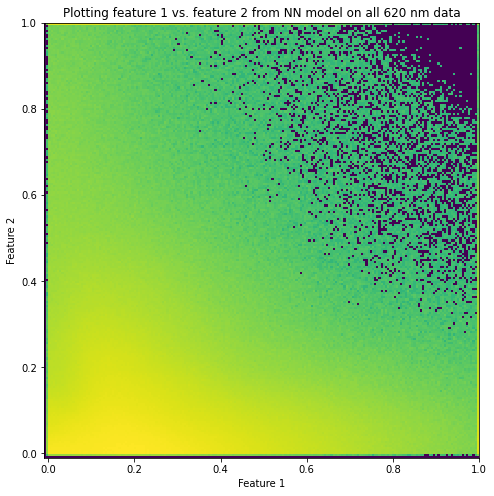

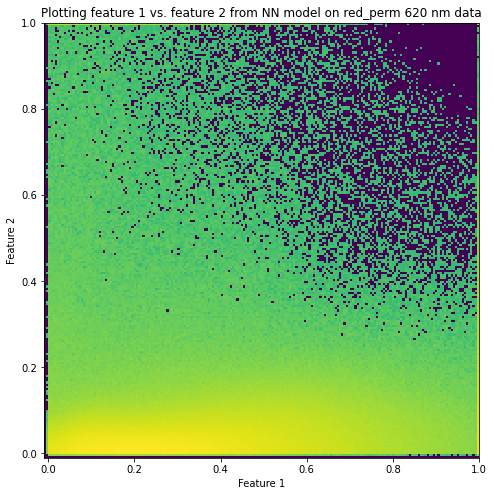

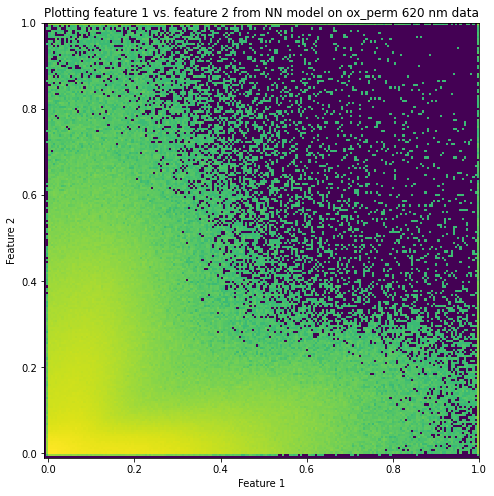

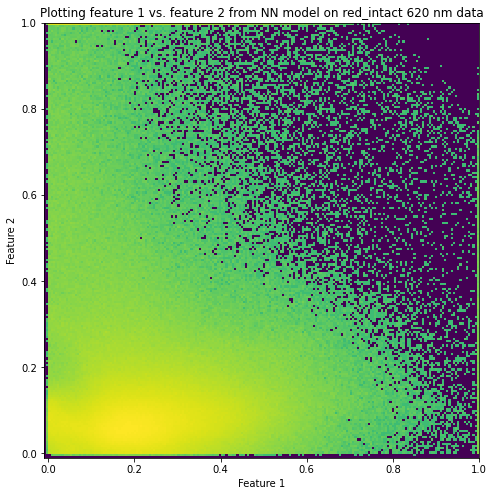

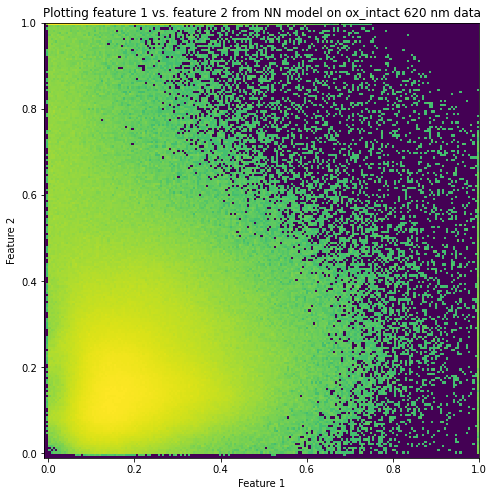

In [161]:
eps = 1e-7
ind1 = 1
ind2 = 0

# histogram for all predictions
x = preds_rolled[ind1,:]
y = preds_rolled[ind2,:]

xedges = np.linspace(-0.01, 1, 200)
yedges = np.linspace(-0.01, 1, 200)

hist, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist = hist.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on all 620 nm data')
plt.show()

# histogram for red_perm predictions
x = preds_rolled_rp[ind1,:]
y = preds_rolled_rp[ind2,:]

xedges = np.linspace(-0.01, 1, 200)
yedges = np.linspace(-0.01, 1, 200)

hist_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_rp = hist_rp.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_rp + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on red_perm 620 nm data')
plt.show()

# histogram for ox perm predictions
x = preds_rolled_op[ind1,:]
y = preds_rolled_op[ind2,:]

xedges = np.linspace(-0.01, 1, 200)
yedges = np.linspace(-0.01, 1, 200)

hist_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_op = hist_op.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_op + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on ox_perm 620 nm data')
plt.show()

# histogram for reduced intact predictions
x = preds_rolled_ri[ind1,:]
y = preds_rolled_ri[ind2,:]

xedges = np.linspace(-0.01, 1, 200)
yedges = np.linspace(-0.01, 1, 200)

hist_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_ri = hist_ri.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_ri + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on red_intact 620 nm data')
plt.show()


# histogram for oxidized intact predictions
x = preds_rolled_oi[ind1,:]
y = preds_rolled_oi[ind2,:]

xedges = np.linspace(-0.01, 1, 200)
yedges = np.linspace(-0.01, 1, 200)

hist_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_oi = hist_oi.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_oi + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on ox_intact 620 nm data')
plt.show()

# Experiment with new features

In [162]:
img_stack_np = img_stack.detach().cpu().numpy().squeeze()
print(img_stack_np.shape)
img_stack_np = np.swapaxes(img_stack_np, 0 , 3)
print(img_stack_np.shape)

img_stack_rp = img_stack_rp.detach().cpu().numpy().squeeze()
print(img_stack_rp.shape)
img_stack_rp = np.swapaxes(img_stack_rp, 0 , 3)
print(img_stack_rp.shape)

img_stack_op = img_stack_op.detach().cpu().numpy().squeeze()
print(img_stack_op.shape)
img_stack_op = np.swapaxes(img_stack_op, 0 , 3)
print(img_stack_op.shape)

img_stack_ri = img_stack_ri.detach().cpu().numpy().squeeze()
print(img_stack_ri.shape)
img_stack_ri = np.swapaxes(img_stack_ri, 0 , 3)
print(img_stack_ri.shape)

img_stack_oi = img_stack_oi.detach().cpu().numpy().squeeze()
print(img_stack_oi.shape)
img_stack_oi = np.swapaxes(img_stack_oi, 0 , 3)
print(img_stack_oi.shape)

(25, 681, 406, 9)
(9, 681, 406, 25)
(8, 681, 406, 9)
(9, 681, 406, 8)
(5, 681, 406, 9)
(9, 681, 406, 5)
(6, 681, 406, 9)
(9, 681, 406, 6)
(6, 681, 406, 9)
(9, 681, 406, 6)


In [163]:
# convert data from [M, nx, ny, c] to [c, (M*nx*ny)] shape

img_stack_rolled = []
for img in img_stack_np:
    rolled_img = np.ravel(img)
    img_stack_rolled.append(rolled_img)
img_stack_rolled = np.array(img_stack_rolled)
print(img_stack_rolled.shape)

img_stack_rolled_rp = []
for img in img_stack_rp:
    rolled_img = np.ravel(img)
    img_stack_rolled_rp.append(rolled_img)
img_stack_rolled_rp = np.array(img_stack_rolled_rp)
print(img_stack_rolled_rp.shape)

img_stack_rolled_op = []
for img in img_stack_op:
    rolled_img = np.ravel(img)
    img_stack_rolled_op.append(rolled_img)
img_stack_rolled_op = np.array(img_stack_rolled_op)
print(img_stack_rolled_op.shape)

img_stack_rolled_ri = []
for img in img_stack_ri:
    rolled_img = np.ravel(img)
    img_stack_rolled_ri.append(rolled_img)
img_stack_rolled_ri = np.array(img_stack_rolled_ri)
print(img_stack_rolled_ri.shape)

img_stack_rolled_oi = []
for img in img_stack_oi:
    rolled_img = np.ravel(img)
    img_stack_rolled_oi.append(rolled_img)
img_stack_rolled_oi = np.array(img_stack_rolled_oi)
print(img_stack_rolled_oi.shape)

(9, 6912150)
(9, 2211888)
(9, 1382430)
(9, 1658916)
(9, 1658916)


In [164]:
# swap axes to feed data in PCA algorithm
img_stack_rolled = np.swapaxes(img_stack_rolled, 0, 1)
print(img_stack_rolled.shape)
img_stack_rolled_rp = np.swapaxes(img_stack_rolled_rp, 0, 1)
print(img_stack_rolled_rp.shape)
img_stack_rolled_op = np.swapaxes(img_stack_rolled_op, 0, 1)
print(img_stack_rolled_op.shape)
img_stack_rolled_ri = np.swapaxes(img_stack_rolled_ri, 0, 1)
print(img_stack_rolled_ri.shape)
img_stack_rolled_oi = np.swapaxes(img_stack_rolled_oi, 0, 1)
print(img_stack_rolled_oi.shape)

(6912150, 9)
(2211888, 9)
(1382430, 9)
(1658916, 9)
(1658916, 9)


In [165]:
# apply PCA and report metrics
pca = PCA(n_components=3)
pca.fit(img_stack_rolled)
print('PCA explained variance ratio with these components:', pca.explained_variance_ratio_)
print('PCA singular values:', pca.singular_values_)

PCA explained variance ratio with these components: [0.9653884  0.02566989 0.00218746]
PCA singular values: [807.6003   131.69139   38.442867]


In [166]:
stack_pca = pca.transform(img_stack_rolled)
print(stack_pca.shape)
stack_pca_rp = pca.transform(img_stack_rolled_rp)
print(stack_pca_rp.shape)
stack_pca_op = pca.transform(img_stack_rolled_op)
print(stack_pca_op.shape)
stack_pca_ri = pca.transform(img_stack_rolled_ri)
print(stack_pca_ri.shape)
stack_pca_oi = pca.transform(img_stack_rolled_oi)
print(stack_pca_oi.shape)

(6912150, 3)
(2211888, 3)
(1382430, 3)
(1658916, 3)
(1658916, 3)


In [167]:
stack_pca = np.swapaxes(stack_pca, 0, 1)
print(stack_pca.shape)
stack_pca_rp = np.swapaxes(stack_pca_rp, 0, 1)
print(stack_pca_rp.shape)
stack_pca_op = np.swapaxes(stack_pca_op, 0, 1)
print(stack_pca_op.shape)
stack_pca_ri = np.swapaxes(stack_pca_ri, 0, 1)
print(stack_pca_ri.shape)
stack_pca_oi = np.swapaxes(stack_pca_oi, 0, 1)
print(stack_pca_oi.shape)

(3, 6912150)
(3, 2211888)
(3, 1382430)
(3, 1658916)
(3, 1658916)


In [168]:
# reshape the data back to regular image sizes
stack_pca_reshaped = []
for data in stack_pca:
    data = np.reshape(data, (681, 406, 25))
    stack_pca_reshaped.append(data)
stack_pca_reshaped = np.array(stack_pca_reshaped)
print(stack_pca_reshaped.shape)
stack_pca_reshaped = np.swapaxes(stack_pca_reshaped, 0, 3)
print(stack_pca_reshaped.shape)

stack_pca_reshaped_rp = []
for data in stack_pca_rp:
    data = np.reshape(data, (681, 406, len(red_perm)))
    stack_pca_reshaped_rp.append(data)
stack_pca_reshaped_rp = np.array(stack_pca_reshaped_rp)
print(stack_pca_reshaped_rp.shape)
stack_pca_reshaped_rp = np.swapaxes(stack_pca_reshaped_rp, 0, 3)
print(stack_pca_reshaped_rp.shape)

stack_pca_reshaped_op = []
for data in stack_pca_op:
    data = np.reshape(data, (681, 406, len(ox_perm)))
    stack_pca_reshaped_op.append(data)
stack_pca_reshaped_op = np.array(stack_pca_reshaped_op)
print(stack_pca_reshaped_op.shape)
stack_pca_reshaped_op = np.swapaxes(stack_pca_reshaped_op, 0, 3)
print(stack_pca_reshaped_op.shape)

stack_pca_reshaped_ri = []
for data in stack_pca_ri:
    data = np.reshape(data, (681, 406, len(red_intact)))
    stack_pca_reshaped_ri.append(data)
stack_pca_reshaped_ri = np.array(stack_pca_reshaped_ri)
print(stack_pca_reshaped_ri.shape)
stack_pca_reshaped_ri = np.swapaxes(stack_pca_reshaped_ri, 0, 3)
print(stack_pca_reshaped_ri.shape)

stack_pca_reshaped_oi = []
for data in stack_pca_oi:
    data = np.reshape(data, (681, 406, len(ox_intact)))
    stack_pca_reshaped_oi.append(data)
stack_pca_reshaped_oi = np.array(stack_pca_reshaped_oi)
print(stack_pca_reshaped_oi.shape)
stack_pca_reshaped_oi = np.swapaxes(stack_pca_reshaped_oi, 0, 3)
print(stack_pca_reshaped_oi.shape)

(3, 681, 406, 25)
(25, 681, 406, 3)
(3, 681, 406, 8)
(8, 681, 406, 3)
(3, 681, 406, 5)
(5, 681, 406, 3)
(3, 681, 406, 6)
(6, 681, 406, 3)
(3, 681, 406, 6)
(6, 681, 406, 3)


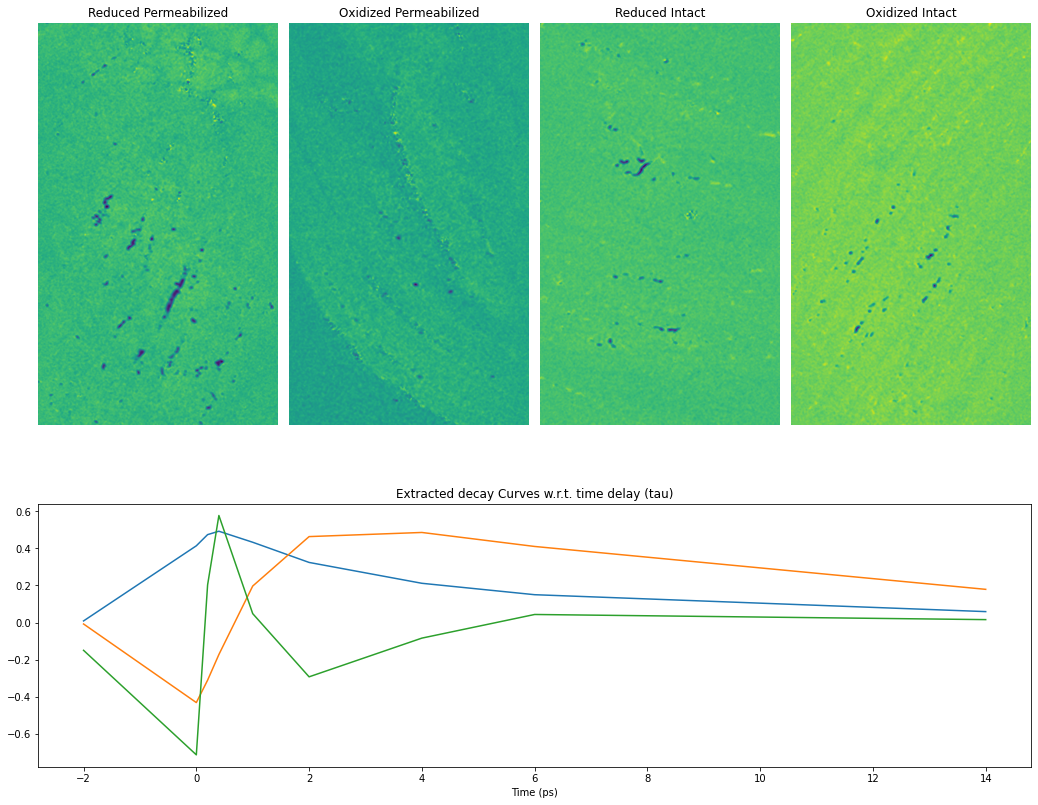

In [169]:
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(18)
 
ax1 = plt.subplot2grid(shape=(3, 5), loc=(0, 0), rowspan=2)
ax2 = plt.subplot2grid(shape=(3, 5), loc=(0, 1), rowspan=2)
ax3 = plt.subplot2grid(shape=(3, 5), loc=(0, 2), rowspan=2)
ax4 = plt.subplot2grid(shape=(3, 5), loc=(0, 3), rowspan=2)
ax5 = plt.subplot2grid(shape=(3, 5), loc=(2, 0), colspan=4)
 
# plotting subplots
ax1.imshow(stack_pca_reshaped[0,:,:,2])
ax1.set_title('Reduced Permeabilized')
ax1.set_axis_off()
ax2.imshow(stack_pca_reshaped[1,:,:,2])
ax2.set_axis_off()
ax2.set_title('Oxidized Permeabilized')
ax3.imshow(stack_pca_reshaped[4,:,:,2])
ax3.set_axis_off()
ax3.set_title('Reduced Intact')
ax4.imshow(stack_pca_reshaped[5,:,:,2])
ax4.set_axis_off()
ax4.set_title('Oxidized Intact')
ax5.plot(tau, np.transpose(pca.components_))
ax5.set_title('Extracted decay Curves w.r.t. time delay (tau)')
ax5.set_xlabel('Time (ps)')
 
# automatically adjust padding horizontally
# as well as vertically.
plt.tight_layout()
 
# display plot
plt.show()

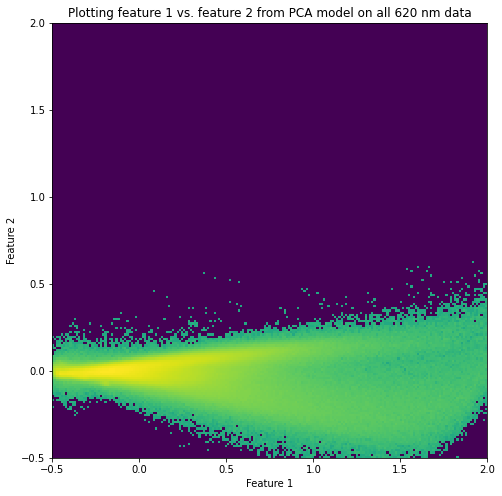

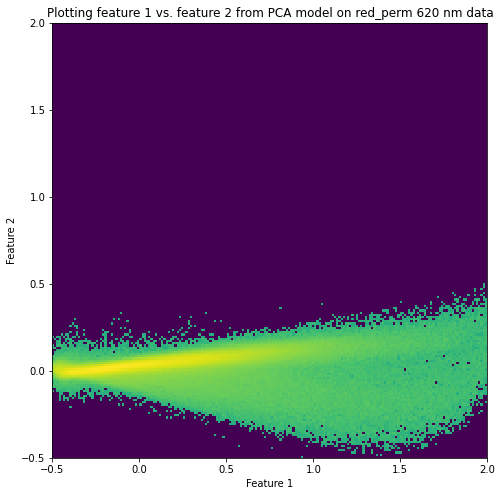

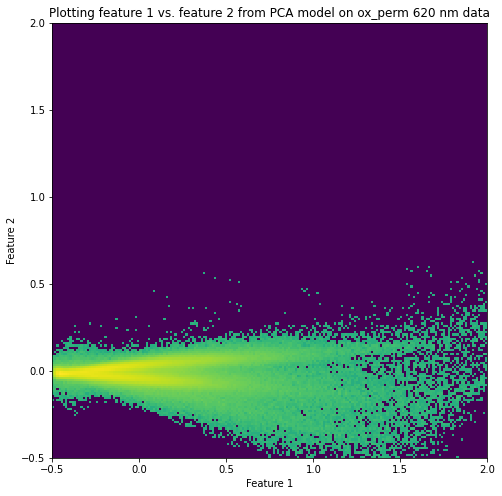

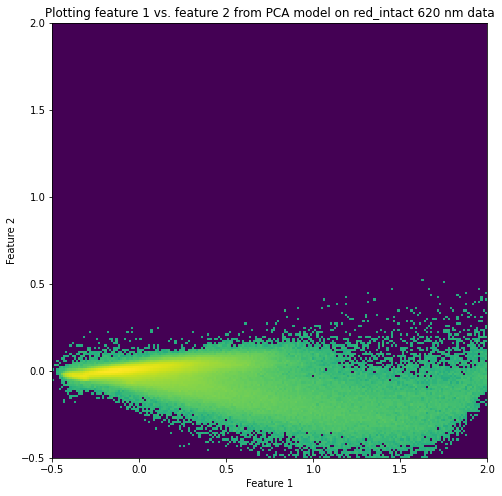

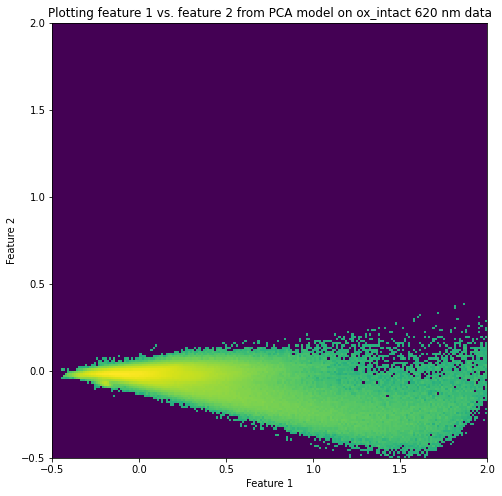

In [170]:
# plot 2D histogram of the PCA analysis

x = stack_pca[0, :]
y = stack_pca[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist = hist.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from PCA model on all 620 nm data')
plt.show()


x = stack_pca_rp[0, :]
y = stack_pca_rp[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_rp_pca, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_rp_pca = hist_rp_pca.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_rp_pca + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from PCA model on red_perm 620 nm data')
plt.show()

x = stack_pca_op[0, :]
y = stack_pca_op[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_op_pca, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_op_pca = hist_op_pca.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_op_pca + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from PCA model on ox_perm 620 nm data')
plt.show()


x = stack_pca_ri[0, :]
y = stack_pca_ri[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_ri_pca, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_ri_pca = hist_ri_pca.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_ri_pca + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from PCA model on red_intact 620 nm data')
plt.show()

x = stack_pca_oi[0, :]
y = stack_pca_oi[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_oi_pca, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_oi_pca = hist_oi_pca.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_oi_pca + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from PCA model on ox_intact 620 nm data')
plt.show()


## Implement SVD 

In [171]:
# apply PCA and report metrics
svd = TruncatedSVD(n_components=3)
svd.fit(img_stack_rolled)
print('SVD explained variance ratio with these components:', svd.explained_variance_ratio_)
print('SVD singular values:', svd.singular_values_)

SVD explained variance ratio with these components: [0.95430785 0.02679579 0.00241536]
SVD singular values: [1460.8553    136.94093    41.544907]


In [172]:
stack_svd = svd.transform(img_stack_rolled)
print(stack_svd.shape)
stack_svd_rp = svd.transform(img_stack_rolled_rp)
print(stack_svd_rp.shape)
stack_svd_op = svd.transform(img_stack_rolled_op)
print(stack_svd_op.shape)
stack_svd_ri = svd.transform(img_stack_rolled_ri)
print(stack_svd_ri.shape)
stack_svd_oi = svd.transform(img_stack_rolled_oi)
print(stack_svd_oi.shape)

(6912150, 3)
(2211888, 3)
(1382430, 3)
(1658916, 3)
(1658916, 3)


In [173]:
stack_svd = np.swapaxes(stack_svd, 0, 1)
print(stack_svd.shape)
stack_svd_rp = np.swapaxes(stack_svd_rp, 0, 1)
print(stack_svd_rp.shape)
stack_svd_op = np.swapaxes(stack_svd_op, 0, 1)
print(stack_svd_op.shape)
stack_svd_ri = np.swapaxes(stack_svd_ri, 0, 1)
print(stack_svd_ri.shape)
stack_svd_oi = np.swapaxes(stack_svd_oi, 0, 1)
print(stack_svd_oi.shape)

(3, 6912150)
(3, 2211888)
(3, 1382430)
(3, 1658916)
(3, 1658916)


In [174]:
# reshape the data back to regular image sizes
stack_svd_reshaped = []
for data in stack_svd:
    data = np.reshape(data, (681, 406, 25))
    stack_svd_reshaped.append(data)
stack_svd_reshaped = np.array(stack_svd_reshaped)
print(stack_svd_reshaped.shape)
stack_svd_reshaped = np.swapaxes(stack_svd_reshaped, 0, 3)
print(stack_svd_reshaped.shape)

(3, 681, 406, 25)
(25, 681, 406, 3)


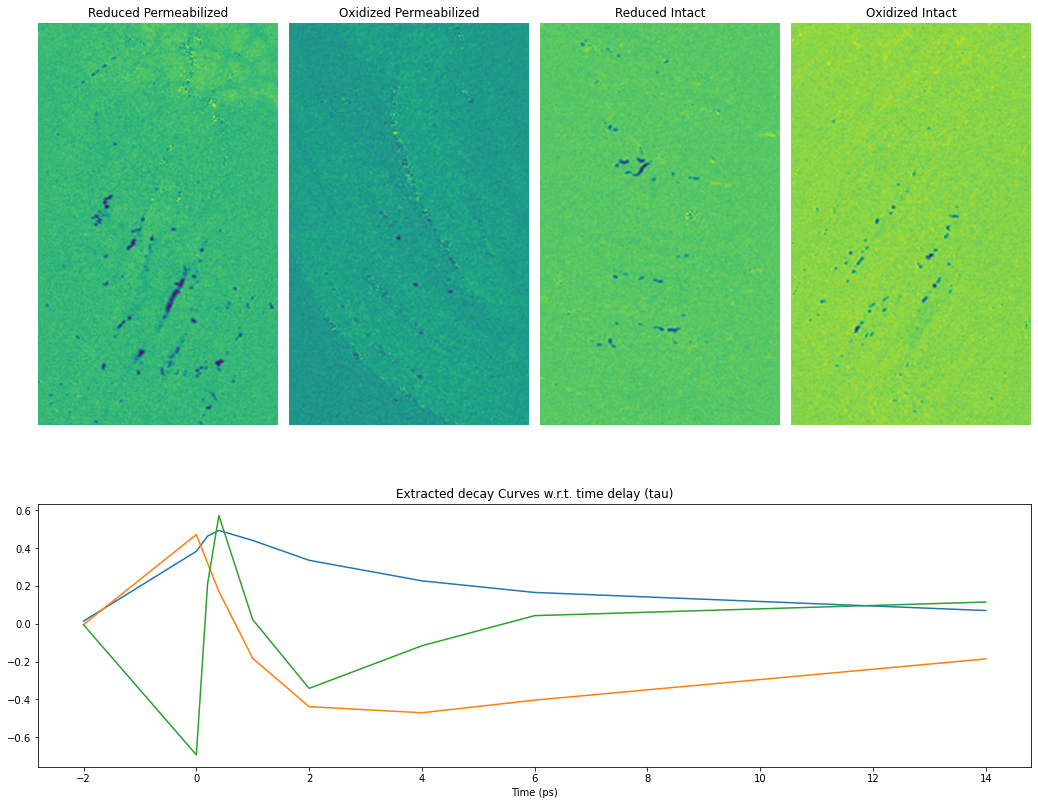

In [175]:
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(18)
 
ax1 = plt.subplot2grid(shape=(3, 5), loc=(0, 0), rowspan=2)
ax2 = plt.subplot2grid(shape=(3, 5), loc=(0, 1), rowspan=2)
ax3 = plt.subplot2grid(shape=(3, 5), loc=(0, 2), rowspan=2)
ax4 = plt.subplot2grid(shape=(3, 5), loc=(0, 3), rowspan=2)
ax5 = plt.subplot2grid(shape=(3, 5), loc=(2, 0), colspan=4)
 
# plotting subplots
ax1.imshow(stack_svd_reshaped[0,:,:,2])
ax1.set_title('Reduced Permeabilized')
ax1.set_axis_off()
ax2.imshow(stack_svd_reshaped[1,:,:,2])
ax2.set_axis_off()
ax2.set_title('Oxidized Permeabilized')
ax3.imshow(stack_svd_reshaped[4,:,:,2])
ax3.set_axis_off()
ax3.set_title('Reduced Intact')
ax4.imshow(stack_svd_reshaped[5,:,:,2])
ax4.set_axis_off()
ax4.set_title('Oxidized Intact')
ax5.plot(tau, np.transpose(svd.components_))
ax5.set_title('Extracted decay Curves w.r.t. time delay (tau)')
ax5.set_xlabel('Time (ps)')
 
# automatically adjust padding horizontally
# as well as vertically.
plt.tight_layout()
 
# display plot
plt.show()

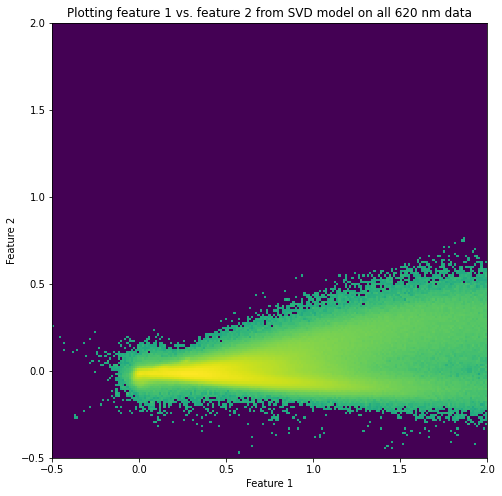

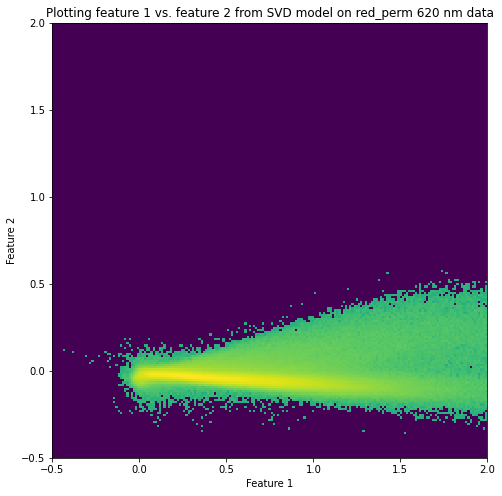

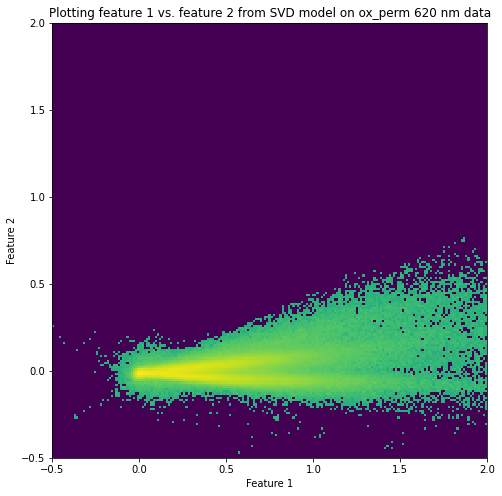

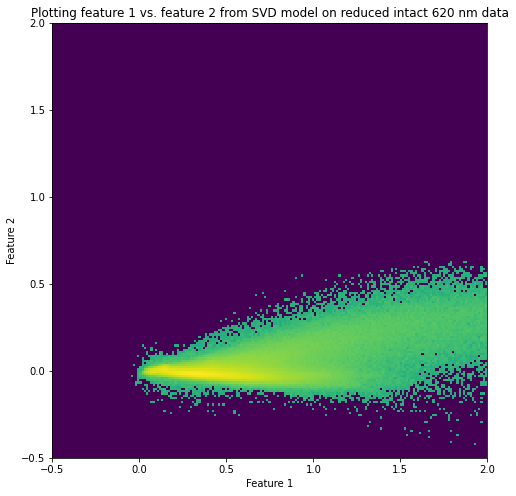

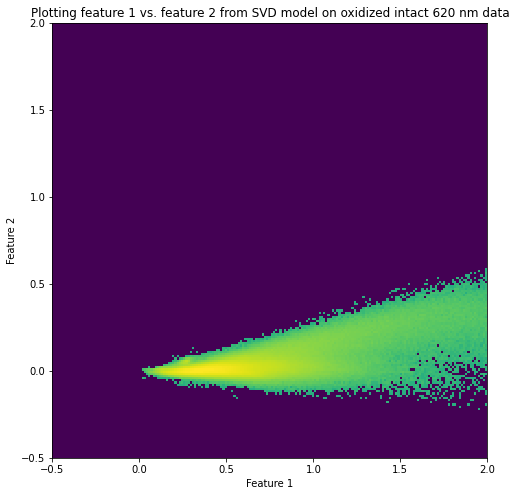

In [176]:
# plot 2D histogram of the SVD analysis

x = stack_svd[0, :]
y = stack_svd[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_svd, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd = hist_svd.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_svd + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on all 620 nm data')
plt.show()


x = stack_svd_rp[0, :]
y = stack_svd_rp[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_svd_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_rp = hist_svd_rp.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_svd_rp + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on red_perm 620 nm data')
plt.show()


x = stack_svd_op[0, :]
y = stack_svd_op[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_svd_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_op = hist_svd_op.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_svd_op + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on ox_perm 620 nm data')
plt.show()


x = stack_svd_ri[0, :]
y = stack_svd_ri[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_svd_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_ri = hist_svd_ri.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_svd_ri + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on reduced intact 620 nm data')
plt.show()


x = stack_svd_oi[0, :]
y = stack_svd_oi[1, :]

xedges = np.linspace(-0.5, 2, 200)
yedges = np.linspace(-0.5, 2, 200)

hist_svd_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_oi = hist_svd_oi.T

plt.figure(figsize=(8,8))
plt.imshow(np.log(hist_svd_oi + eps), interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on oxidized intact 620 nm data')
plt.show()

## KL/JS divergence calculation

In [212]:
eps = 1e-7

In [229]:
A = hist_op + eps
B = hist_oi + eps
print(A.shape, B.shape)

## Adjust so the sum of the PDFs equals 1. 
sum_A = A/np.sum(A)
sum_B = B/np.sum(B)

print('KL(A || B): %.5f nats' %kl_divergence(sum_A, sum_B))
print('KL(B || A): %.5f nats' %kl_divergence(sum_B, sum_A))

js_ab = js_divergence(sum_A, sum_B)
print('JS(A || B) divergence: %.3f nats' % js_ab)
print('JS(A || B) distance: %.3f' % sqrt(js_ab))

js_ba = js_divergence(sum_B, sum_A)
print('JS(B || A) divergence: %.3f nats' % js_ba)
print('JS(B || A) distance: %.3f' % sqrt(js_ba))

(199, 199) (199, 199)
KL(A || B): 1.67422 nats
KL(B || A): 1.16492 nats
JS(A || B) divergence: 0.239 nats
JS(A || B) distance: 0.489
JS(B || A) divergence: 0.239 nats
JS(B || A) distance: 0.489


In [232]:
A = hist_op_pca + eps
B = hist_oi_pca + eps
print(A.shape, B.shape)

## Adjust so the sum of the PDFs equals 1. 
sum_A = A/np.sum(A)
sum_B = B/np.sum(B)

print('KL(A || B): %.5f nats' %kl_divergence(sum_A, sum_B))
print('KL(B || A): %.5f nats' %kl_divergence(sum_B, sum_A))

js_ab = js_divergence(sum_A, sum_B)
print('JS(A || B) divergence: %.3f nats' % js_ab)
print('JS(A || B) distance: %.3f' % sqrt(js_ab))

js_ba = js_divergence(sum_B, sum_A)
print('JS(B || A) divergence: %.3f nats' % js_ba)
print('JS(B || A) distance: %.3f' % sqrt(js_ba))

(199, 199) (199, 199)
KL(A || B): 3.96364 nats
KL(B || A): 1.09789 nats
JS(A || B) divergence: 0.255 nats
JS(A || B) distance: 0.505
JS(B || A) divergence: 0.255 nats
JS(B || A) distance: 0.505


In [235]:
A = hist_svd_op + eps
B = hist_svd_oi + eps
print(A.shape, B.shape)

## Adjust so the sum of the PDFs equals 1. 
sum_A = A/np.sum(A)
sum_B = B/np.sum(B)

print('KL(A || B): %.5f nats' %kl_divergence(sum_A, sum_B))
print('KL(B || A): %.5f nats' %kl_divergence(sum_B, sum_A))

js_ab = js_divergence(sum_A, sum_B)
print('JS(A || B) divergence: %.3f nats' % js_ab)
print('JS(A || B) distance: %.3f' % sqrt(js_ab))

js_ba = js_divergence(sum_B, sum_A)
print('JS(B || A) divergence: %.3f nats' % js_ba)
print('JS(B || A) distance: %.3f' % sqrt(js_ba))

(199, 199) (199, 199)
KL(A || B): 3.84653 nats
KL(B || A): 1.07152 nats
JS(A || B) divergence: 0.253 nats
JS(A || B) distance: 0.503
JS(B || A) divergence: 0.253 nats
JS(B || A) distance: 0.503
